<!-- ![](./title_lab_1.png) -->
<p align="center">
  <img src = './title_lab_1.png' alt='титульник'>
</p>


## Цель работы 
Изучение различных методов визуализация данных и создание истории на основе данных

## Задание
- Выбрать набор данных (датасет). Вы можете найти список свободно распространяемых датасетов здесь.
Для лабораторных работ не рекомендуется выбирать датасеты очень большого размера.
- Создать "историю о данных" в виде юпитер-ноутбука, с учетом следующих требований:
  1.	История должна содержать не менее 5 шагов (где 5 - рекомендуемое количество шагов). Каждый шаг содержит график и его текстовую интерпретацию.
  2.	На каждом шаге наряду с удачным итоговым графиком рекомендуется в юпитер-ноутбуке оставлять результаты предварительных "неудачных" графиков.
  3.	Не рекомендуется повторять виды графиков, желательно создать 5 графиков различных видов.
  4.	Выбор графиков должен быть обоснован использованием методологии data-to-viz. Рекомендуется учитывать типичные ошибки построения выбранного вида графика по методологии data-to-viz. Если методология Вами отвергается, то просьба обосновать Ваше решение по выбору графика.
  5.	История должна содержать итоговые выводы. В реальных "историях о данных" именно эти выводы представляют собой основную ценность для предприятия.
- Сформировать отчет и разместить его в своем репозитории на github.
Средства и способы визуализации данных можно посмотреть здесь.

## Ход работы

In [520]:
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import math

%matplotlib inline

Взял датасет **Demographic and Socio-economic Indicators - last update: September 2023** https://uis.unesco.org/bdds

В нем собраны различные социально-демографические и экономические метрики с разных стран по годам.

- INDICATOR_ID - код социально-демографической или экономической метрики. Категориальный признак.
- COUNTRY_ID - код государства. Категориальный признак.
- YEAR - год. Категориальный признак.
- VALUE	- значение этой социально-демографической или экономической метрики. Числовой признак.
- MAGNITUDE - пустая колонка
- QUALIFIER - пустая колонка

За некоторые года некоторые метрики могут быть пропущены. Это связано с тем, что расчеты по некоторым показателям не могли быть проведены из-за отсутствия данных. Либо эти данных никто не собирал, как в некоторых странах стретьего мира, либо эти страны имеют закрытую экономику, как Иран и КНДР. Однако, это нельзя считать полноценными пропусками. Если за такой-то год данные по такой-то метрике не были собраны, строка с такой страной, годом и метрикой просто будет отсутствовать. 

Также существует проблема, что данные о стране А собираются с 1900 года, а о стране Б - с 2000.

Для полноценного анализа, **исходный датасет нужно разбить** на более мелкие датасеты либо по исследуемой социально-демографической или экономической метрике, либо по стране.


In [521]:
data_folder = '../data/'
countries_labels = pd.read_csv(data_folder + 'DEM_COUNTRY.csv')
indicator_labels = pd.read_csv(data_folder + 'DEM_LABEL.csv')
data_raw = pd.read_csv(data_folder + 'DEM_DATA_NATIONAL.csv')

In [522]:
data_raw

,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE,MAGNITUDE,QUALIFIER
0,200101,ABW,1970,5.924000e+01,NaN,NaN
1,200101,ABW,1971,5.897300e+01,NaN,NaN
2,200101,ABW,1972,5.866000e+01,NaN,NaN
3,200101,ABW,1973,5.905100e+01,NaN,NaN
4,200101,ABW,1974,5.968000e+01,NaN,NaN
...,...,...,...,...,...,...
303304,XTGOV.IMF,ZWE,2019,2.484000e+10,NaN,NaN
303305,XTGOV.IMF,ZWE,2020,1.726850e+11,NaN,NaN
303306,XTGOV.IMF,ZWE,2021,5.583440e+11,NaN,NaN
303307,XTGOV.IMF,ZWE,2022,2.329145e+12,NaN,NaN


Есть строки с большим количеством NaN. Узнаем, есть ли среди них полезные.

In [523]:
data_raw[~data_raw['MAGNITUDE'].isna()]

,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE,MAGNITUDE,QUALIFIER


In [524]:
data_raw[~data_raw['QUALIFIER'].isna()]

,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE,MAGNITUDE,QUALIFIER


Полезных нет. Эти 2 колонки можно удалить

In [525]:
df = data_raw.dropna(axis='columns', how='all')
df

,INDICATOR_ID,COUNTRY_ID,YEAR,VALUE
0,200101,ABW,1970,5.924000e+01
1,200101,ABW,1971,5.897300e+01
2,200101,ABW,1972,5.866000e+01
3,200101,ABW,1973,5.905100e+01
4,200101,ABW,1974,5.968000e+01
...,...,...,...,...
303304,XTGOV.IMF,ZWE,2019,2.484000e+10
303305,XTGOV.IMF,ZWE,2020,1.726850e+11
303306,XTGOV.IMF,ZWE,2021,5.583440e+11
303307,XTGOV.IMF,ZWE,2022,2.329145e+12


Составляю словари для перевода кратких обозначений стран и параметров

In [526]:
def two_lists_to_dict(keys, values):
  res = {}
  for key in keys:
      for value in values:
          res[key] = value
          values.remove(value)
          break
  return res

In [527]:
countries_labels = countries_labels.to_dict('list')
countries_labels = two_lists_to_dict(countries_labels['COUNTRY_ID'], countries_labels['COUNTRY_NAME_EN'])

indicator_labels = indicator_labels.to_dict('list')
indicator_labels = two_lists_to_dict(indicator_labels['INDICATOR_ID'], indicator_labels['INDICATOR_LABEL_EN'])


### Первая история - рост ВВП КНР

GDP (current LCU)


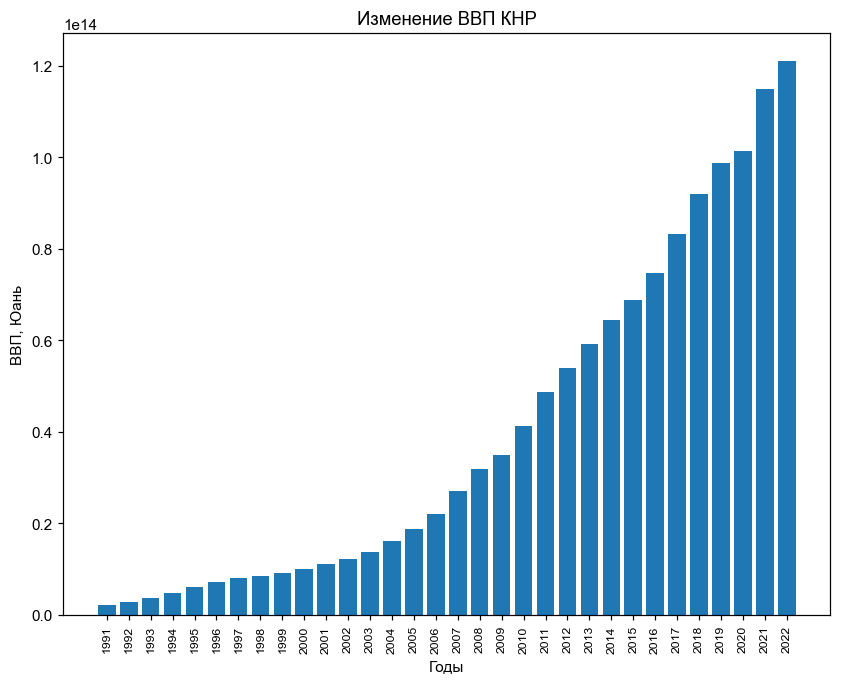

In [528]:
print(indicator_labels['NY.GDP.MKTP.CN'])
china_gdp = df[(df['INDICATOR_ID'] == 'NY.GDP.MKTP.CN') & (df['COUNTRY_ID'] == 'CHN') & (df['YEAR'] >= 1991)][['YEAR', 'VALUE']]
X = china_gdp['YEAR']
Y = china_gdp['VALUE'].values

Y_red = np.zeros(len(Y))
Y_blue = np.array(Y)
for i in range(1, len(Y)):
  if Y[i-1] > Y[i]:
     Y_red[i] = Y[i]
     Y_blue[i] = 0

fig, ax1 = plt.subplots(figsize=(9, 7),  # width, height in inches
                        dpi=110)         # resolution of the figure

y_pos = np.arange(china_gdp.shape[0]) # сетка

# move x axes to zero
ax1.spines['bottom'].set_position('zero')
# Create names on the x-axis
plt.xticks(y_pos, X, rotation='vertical', fontsize=8)

plt.xlabel('Годы') # Подпись для оси х
plt.ylabel('ВВП, Юань')
plt.title('Изменение ВВП КНР')

bar1 = plt.bar(y_pos, Y_red, color='red') # legend = 'Прирост ВВП, %'
bar2 = plt.bar(y_pos, Y_blue) # legend = 'Прирост ВВП, %'

plt.show()

### Вторая история - прирост ВВП КНР от года к году

- Красным отмечено падение роста к значению роста предыдущего года
- Синим отмечено увеличение роста к значению роста предыдущего года

GDP growth (annual %)


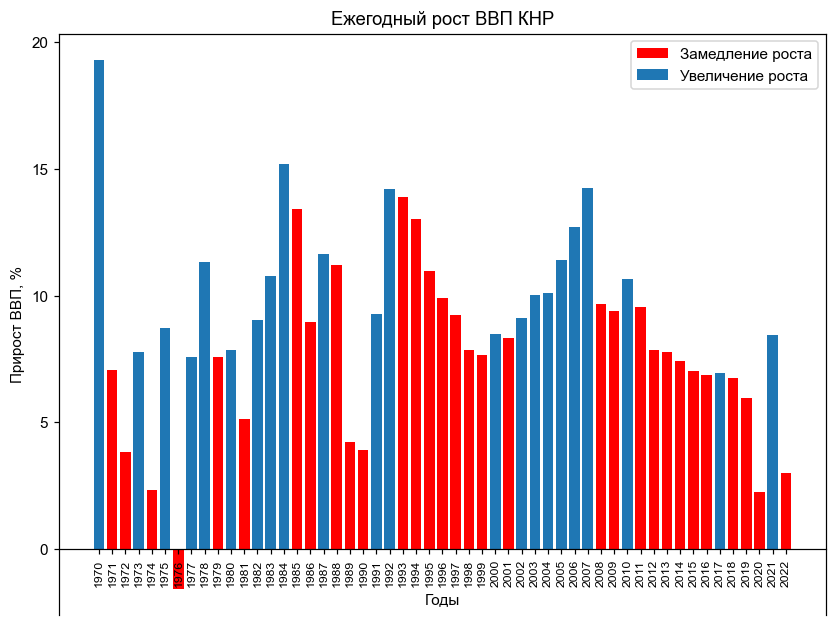

In [529]:
print(indicator_labels['NY.GDP.MKTP.KD.ZG'])

china_gdp = df[(df['INDICATOR_ID'] == 'NY.GDP.MKTP.KD.ZG') & (df['COUNTRY_ID'] == 'CHN')][['YEAR', 'VALUE']]
X = china_gdp['YEAR']
Y = china_gdp['VALUE'].values

Y_red = np.zeros(len(Y))
Y_blue = np.array(Y)
for i in range(1, len(Y)):
  if Y[i-1] > Y[i]:
     Y_red[i] = Y[i]
     Y_blue[i] = 0

fig, ax1 = plt.subplots(figsize=(9, 7),  # width, height in inches
                        dpi=110)         # resolution of the figure

y_pos = np.arange(china_gdp.shape[0]) # сетка

# move x axes to zero
ax1.spines['bottom'].set_position('zero')
# # Create names on the x-axis
plt.xticks(y_pos, X, rotation='vertical', fontsize=8)

plt.xlabel('Годы') # Подпись для оси х
plt.ylabel('Прирост ВВП, %')
plt.title('Ежегодный рост ВВП КНР')

bar1 = plt.bar(y_pos, Y_red, color='red') # legend = 'Прирост ВВП, %'
bar2 = plt.bar(y_pos, Y_blue) # legend = 'Прирост ВВП, %'

# Show graphic
plt.legend([bar1, bar2], ['Замедление роста', 'Увеличение роста'])
plt.show()

### Третья история - Относительное изменение ВВП азиатских стран с 2000 года

Выбраны страны, соседствующие с Китаем, в предположении, что регион развивается равномерно.

Значения ВВП взяты в долларах и нормализованы, чтобы показать относительное изменение. Абсолюные значения можно оценить по приведенным на графике формулам.

In [530]:
def get_indicator_of_countries(indicator, countries, since = None):
  print(indicator_labels[indicator])
  print(*map(lambda x: countries_labels[x], countries))
  dfs = {}
  for country in countries:
    china_gdp_growth = df[(df['INDICATOR_ID'] == indicator) & (df['COUNTRY_ID'] == country)][['YEAR', 'VALUE']]
    china_gdp_growth.rename(columns={'VALUE': country}, inplace=True)
    dfs[country] = china_gdp_growth

  first_country = list(dfs.keys())[0]
  res_df = dfs[first_country]
  del dfs[first_country]

  for country in dfs:
    country_df = dfs[country]
    res_df = pd.merge(res_df, country_df, on=['YEAR'])
  res_df = res_df.sort_values('YEAR')

  if since != None:
    res_df = res_df[res_df['YEAR'] >= since]

  return res_df

In [531]:
asia_countries = ('CHN', 'KAZ', 'IND', 'MNG', 'PAK')
countries_gdp = get_indicator_of_countries('NY.GDP.MKTP.CD', asia_countries, since=2000)
countries_gdp_growth = get_indicator_of_countries('NY.GDP.MKTP.KD.ZG', asia_countries)

GDP (current US$)
China Kazakhstan India Mongolia Pakistan
GDP growth (annual %)
China Kazakhstan India Mongolia Pakistan


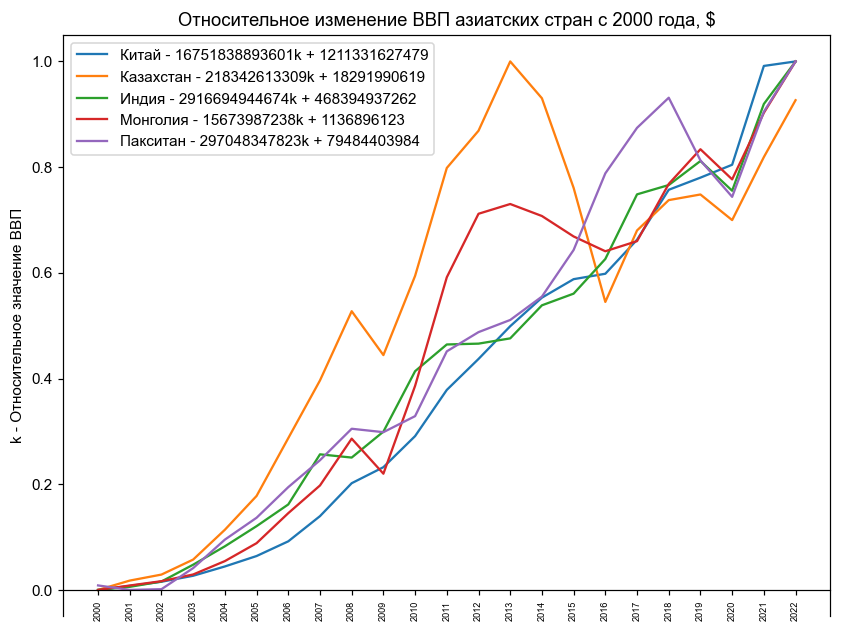

In [532]:
years = countries_gdp['YEAR']
Y_chn = countries_gdp['CHN'].values
Y_kaz = countries_gdp['KAZ'].values
Y_ind = countries_gdp['IND'].values
Y_mng = countries_gdp['MNG'].values
Y_pak = countries_gdp['PAK'].values

def normalize(x):
  minimum = math.floor(np.min(x))
  maximum = math.ceil(np.max(x))
  x_norm = np.subtract(x, minimum) / (maximum - minimum)
  return (x_norm, maximum - minimum, minimum)


def build(ax: plt.Axes, X, Ys, names): 
  Ys_norm = list(map(lambda y: normalize(y), Ys))
  y_pos = np.arange(len(X)) # сетка

  # move x axes to zero
  ax.spines['bottom'].set_position('zero')

  # set properties for axes object (ticks for all issues with labels)
  ax.set_xticks(y_pos, X, rotation='vertical', fontsize=6)

  ax.set_ylabel('k - Относительное значение ВВП')
  ax.title.set_text('Относительное изменение ВВП азиатских стран с 2000 года, $')

  for i in range(len(Ys_norm)):
    y, k, b = Ys_norm[i]
    ax.plot(y, label=f'{names[i]} - {k}k + {b}')

  ax.legend()
  

fig, ax = plt.subplots(1, 1, figsize=(9, 7), dpi=110)
build(ax, years, [Y_chn, Y_kaz, Y_ind, Y_mng, Y_pak], ['Китай', 'Казахстан', 'Индия', 'Монголия', 'Пакситан'])


### Четвертая история - Ежегодный прирост ВВП стран на фоне КНР

Оценивается развитие стран региона на фоне развития страны с крупнейшей экономикой - Китая.

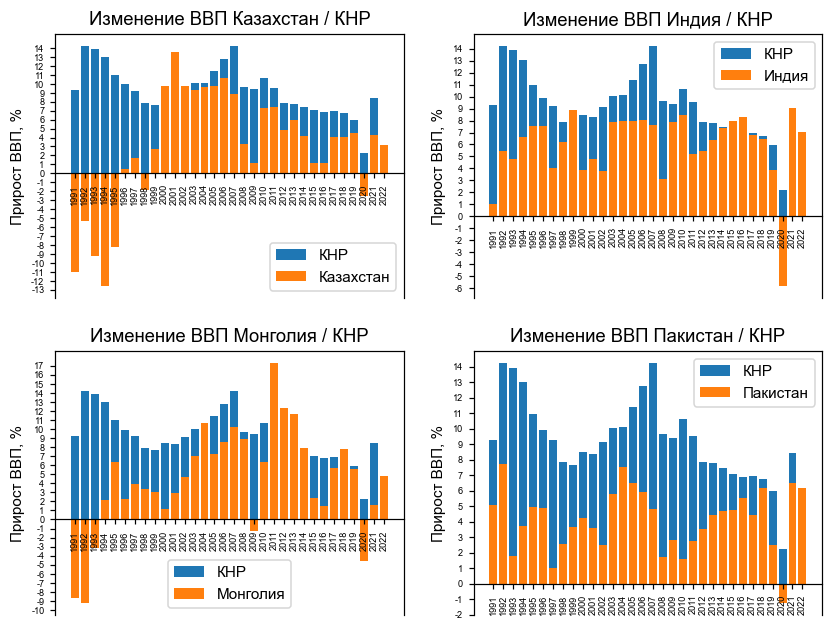

In [533]:
years = countries_gdp_growth['YEAR']
Y_chn = countries_gdp_growth['CHN'].values
Y_kaz = countries_gdp_growth['KAZ'].values
Y_ind = countries_gdp_growth['IND'].values
Y_mng = countries_gdp_growth['MNG'].values
Y_pak = countries_gdp_growth['PAK'].values

def build(ax: plt.Axes, X, Y1, Y2, name): 
  y_pos = np.arange(len(X)) # сетка

  # move x axes to zero
  ax.spines['bottom'].set_position('zero')

  # set properties for axes object (ticks for all issues with labels)
  Y_labels = list(range(int(math.floor(min(np.min(Y1), np.min(Y2)))), int(math.ceil(max(np.max(Y1), np.max(Y2))))))
  ax.set_yticks(Y_labels, Y_labels, fontsize=6)
  ax.set_xticks(y_pos, X, rotation='vertical', fontsize=6)

  ax.set_ylabel('Прирост ВВП, %')
  ax.title.set_text('Изменение ВВП ' + name + ' / КНР')

  bar1 = ax.bar(y_pos, Y1)
  bar2 = ax.bar(y_pos, Y2)
  ax.legend([bar1, bar2], ['КНР', name])
  

fig, axs = plt.subplots(2,2, figsize=(9, 7),  # width, height in inches
                        dpi=110)         # resolution of the figure

build(axs[0, 0], years, Y_chn, Y_kaz, 'Казахстан')
build(axs[0, 1], years, Y_chn, Y_ind, 'Индия')
build(axs[1, 0], years, Y_chn, Y_mng, 'Монголия')
build(axs[1, 1], years, Y_chn, Y_pak, 'Пакистан')

### Пятая история. Изменение структура населения КНР

Показано постепенное старение населения с развитием страны

In [534]:
def get_china_population(since = None):
  indicators = ('200101', '200343', '200144', '200345', '200151')
  country = 'CHN'
  print(*map(lambda x: indicator_labels[x] + '\n', indicators))
  print(*map(lambda x: countries_labels[x], [country]))
  dfs = {}
  for indicator in indicators:
    china_gdp_growth = df[(df['INDICATOR_ID'] == indicator) & (df['COUNTRY_ID'] == country)][['YEAR', 'VALUE']]
    china_gdp_growth.rename(columns={'VALUE': indicator}, inplace=True)
    dfs[indicator] = china_gdp_growth

  first_indicator = list(dfs.keys())[0]
  res_df = dfs[first_indicator]
  del dfs[first_indicator]

  for indicator in dfs:
    indicator_df = dfs[indicator]
    res_df = pd.merge(res_df, indicator_df, on=['YEAR'])
  res_df = res_df.sort_values('YEAR')

  if since != None:
    res_df = res_df[res_df['YEAR'] >= since]

  return res_df

In [535]:
china_population = get_china_population()

china_population.head()

Total population (thousands)
 Population aged 14 years or younger (thousands)
 Population aged 15-24 years (thousands)
 Population aged 25-64 years (thousands) 
 Population aged 65 years or older (thousands)

China


,YEAR,200101,200343,200144,200345,200151
0,1970,811787.180,332560.087,154625.054,294574.102,30027.937
1,1971,833281.720,340161.070,162832.591,299242.462,31045.597
2,1972,853289.127,347269.299,169073.245,304856.818,32089.765
3,1973,872391.679,351735.882,176368.751,311184.075,33102.971
4,1974,890912.481,358160.046,179993.957,318468.957,34289.521


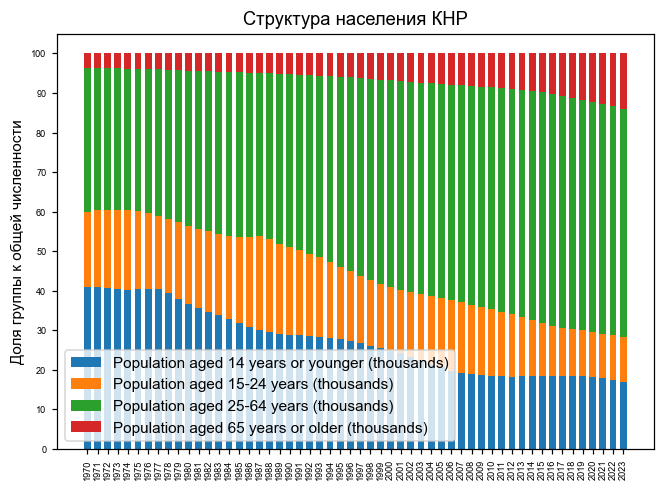

In [536]:
def build(ax: plt.Axes):
  X = china_population['YEAR']
  # перевод в проценты
  Y1 = 100 * china_population['200343'] / china_population['200101']
  Y2 = 100 * china_population['200144'] / china_population['200101']
  Y3 = 100 * china_population['200345'] / china_population['200101']
  Y4 = 100 * china_population['200151'] / china_population['200101']

  Y_labels = list(range(0, 101, 10))
  ax.set_yticks(Y_labels, Y_labels, fontsize=6)
  ax.set_xticks(X, X, rotation='vertical', fontsize=6)

  ax.set_ylabel('Доля группы к общей численности')
  ax.title.set_text('Структура населения КНР')

  bar1 = plt.bar(X, Y1, width=0.68, linewidth=0.9)
  bar2 = plt.bar(X, Y2, width=0.68, bottom=Y1, linewidth=0.9)
  bar3 = plt.bar(X, Y3, width=0.68, bottom=Y1 + Y2, linewidth=0.9)
  bar4 = plt.bar(X, Y4, width=0.68, bottom=Y1 + Y2 + Y3, linewidth=0.9)

  ax.legend([bar1, bar2, bar3, bar4], map(lambda x: indicator_labels[x], ('200343', '200144', '200345', '200151')))

fig, ax = plt.subplots(1,1, figsize=(7, 5), dpi=110)
build(ax)